Thomas Dougherty

Probability and Statistics for Computer Science


### Analysis of the On-Time Performance (OTP) of New Jersey Transit Commuter Rail<br>
On-time performance refers to the level of success of a service adhering to its schedule. In this example I'll be exploring NJT commuter rail from March 2018 to March 2020. On-time performance data can be used for schedule planning, passenger information systems, and comparison to weather data. 
    

In [2]:

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics
import random
import scipy.stats as stats
from csv_funct import *
from helper_functions import *
from math import floor, ceil



#### Data cleanup

In [3]:
#all_services = csv.combine_csvs(r"data/services/")
print("Reading CSV....")
all_services = pd.read_csv(r"data/all_services.csv")
all_services = csv.format_services(all_services)
weather = pd.read_csv(r"data/weather.csv")
weather = csv.format_weather(weather)
all_services

Reading CSV....
Dropping columns...
Changing datatypes...
Done formatting dataframe
Formatting weather dataframe...
Changing datatypes...
Dropping columns...
Done formatting weather dataframe


,date,train_id,from,to,scheduled_time,actual_time,delay_minutes,line
0,2018-08-01,4631,Philadelphia,Philadelphia,2018-08-01 15:19:00,2018-08-01 15:19:14,0.233276,Atl. City Line
1,2018-08-01,4631,Philadelphia,Pennsauken,2018-08-01 15:40:00,2018-08-01 15:40:18,0.300049,Atl. City Line
2,2018-08-01,4631,Pennsauken,Cherry Hill,2018-08-01 15:47:00,2018-08-01 15:48:22,1.366211,Atl. City Line
3,2018-08-01,4631,Cherry Hill,Lindenwold,2018-08-01 15:58:00,2018-08-01 16:03:15,5.250000,Atl. City Line
4,2018-08-01,4631,Lindenwold,Atco,2018-08-01 16:05:00,2018-08-01 16:10:24,5.398438,Atl. City Line
...,...,...,...,...,...,...,...,...
5761579,2019-03-31,6924,Orange,Brick Church,2019-03-31 14:07:00,2019-03-31 14:14:20,7.332031,Morristown Line
5761580,2019-03-31,6924,Brick Church,East Orange,2019-03-31 14:10:00,2019-03-31 14:17:09,7.148438,Morristown Line
5761581,2019-03-31,6924,East Orange,Newark Broad Street,2019-03-31 14:16:00,2019-03-31 14:23:10,7.167969,Morristown Line
5761582,2019-03-31,6924,Newark Broad Street,Secaucus Upper Lvl,2019-03-31 14:25:00,2019-03-31 14:32:01,7.015625,Morristown Line


## Visualization of On Time Performance

#### All Services by Season

Using the date column, arrivals will be divided into four primary categories. The arrivals will be sub-categorized by how many minutes late then plotted onto a pie chart to show on time performance in the seasons of the year. <br>
Pie charts will be used to show the breakdown of how late trains are relative to all trains in the given time periods.

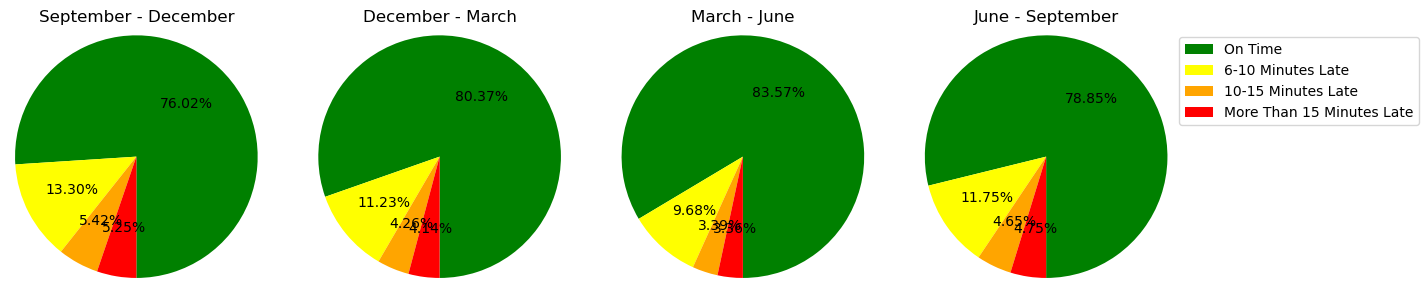

In [4]:
late_labels = ['On Time', '6-10 Minutes Late', '10-15 Minutes Late', 'More Than 15 Minutes Late']
late_colors = ['green', 'yellow', 'orange', 'red']

data_fall = helper.count_lateness(all_services[(all_services['date'].dt.month >= 9) & (all_services['date'].dt.month <= 12)])
# could not get a 'true' boolean value for the winter months and had to broken up into two separate dfs
df1 = all_services[(all_services['date'].dt.month <= 3)]
df2 = all_services[(all_services['date'].dt.month >= 12)]
result = pd.concat([df1,df2])
data_winter = helper.count_lateness(result) 
data_spring = helper.count_lateness(all_services[(all_services['date'].dt.month >= 3) & (all_services['date'].dt.month <=6)])
data_summer = helper.count_lateness(all_services[(all_services['date'].dt.month >= 6) & (all_services['date'].dt.month <=9)])


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

ax1.pie(data_fall, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax1.title.set_text('September - December')
ax2.pie(data_winter, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax2.title.set_text('December - March')
ax3.pie(data_spring, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax3.title.set_text('March - June')
ax4.pie(data_summer, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax4.title.set_text('June - September')

fig.set_figwidth(15)
fig.set_figheight(5)

plt.legend(bbox_to_anchor = (1.0, 1.0), labels = late_labels)
plt.show()

In Autumn, tree leaves tend to fall on the rails. As they're crushed by the weight of the trains, the wheels of the train and the rails they ride on become coated in a low-friction residue. The buildup is incremental with each passing train. So unlike snow, the buildup cannot be prevented by the regular running of trains. These condition makes it difficult for trains to accelerate, decelerate, and maintain safe speeds leading to delays and other service disruptions so we can expect a lower On Time Performance during the autumn months. 

### Reporting to Final Destination On Time: New York Penn Station vs Hoboken Terminal<br>
New York Penn and Hoboken Terminal are two major termini for New Jersey Transit. However, New York Penn is the busiest transportation facility in the western hemisphere serving both commuter and intercity trains whereas Hoboken terminal serves exclusively commuter rail. The North River Tunnels that connect to NYP are aging pieces of infrastructure as well. Built over a century ago, the tunnels under the Hudson River have been experienced flooding, electrical problems, and other issues. The tunnels are operating at capacity and frequently result in congestion and delays.<br>

For easy comparison, bar charts will be used to visualize the OTP of both stations at different peak times. The values between Hoboken and New York Penn are close, so to highlight the difference the limit of the Y-axis has been set to 25 <br>


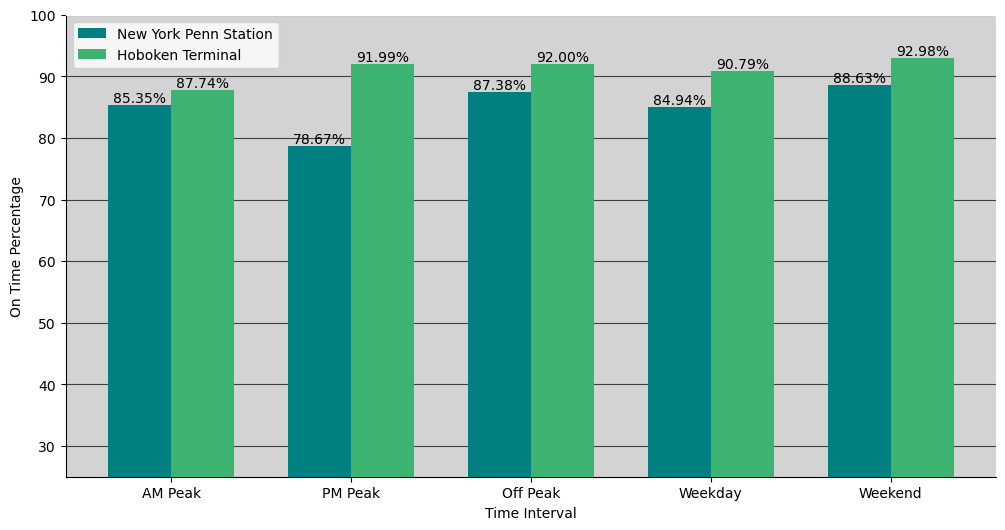

In [5]:
categories = ['AM Peak', 'PM Peak', 'Off Peak', 'Weekday', 'Weekend']

nyp_otps = helper.otp_for_destination(all_services,'New York Penn Station')

hob_otps = helper.otp_for_destination(all_services,'Hoboken')

bar_width = 0.35
index = np.arange(5)
fig, ax = plt.subplots(figsize=(12,6))
nyp = ax.bar(index,nyp_otps, bar_width, label='New York Penn Station', color='teal',zorder=3)
hob = ax.bar(index+bar_width, hob_otps,bar_width, label='Hoboken Terminal', color='mediumseagreen',zorder=3)

ax.set_ylabel('On Time Percentage')
ax.set_ylim(25,100)
ax.set_xlabel('Time Interval')
ax.set_xticks(index+bar_width / 2)
ax.set_xticklabels(categories)
ax.set_facecolor('lightgray')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

ax.legend()
print(1)

for i, bar in enumerate(nyp + hob):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}%', ha='center', va='bottom')

ax.grid(axis='y', linestyle='-', alpha=0.7,color='black',zorder=1)

plt.show()

## Distribution

In [5]:
nyp_services = all_services[(all_services['to'] == 'New York Penn Station')]
late_mins = nyp_services[(nyp_services['delay_minutes'] > 6.0) & (nyp_services['delay_minutes'] < 10.0)]['delay_minutes'].to_list()
#late_mins = nyp_services['delay_minutes'].to_list()
data = late_mins
#data = random.sample(late_mins)
#fig = plt.figure(figsize=(20, 2))
#plt.hist(data, bins = 250)
#plt.title('Distribution of Late Arrivals')
#plt.xlabel('Minutes Late')
#plt.ylabel('Frequency')
plt.show()

## Standard Deviation <br>
An error bar chart will be plotted to show the standard deviation over time. This can be useful for identifying trends and sources of error. If standard deviation is going up over time, then service is more consistent and reliable. If it is going down, service is getting less consistent. <br>

At any given point, low standard deviation indicates that a rail service is consistent in achieving its scheduled arrival times. A higher standard deviation of on-time performance can be interpreted as less reilable or consistent service. It can also indicate inefficient routing of trains or an un-optimized train schedule. <br>


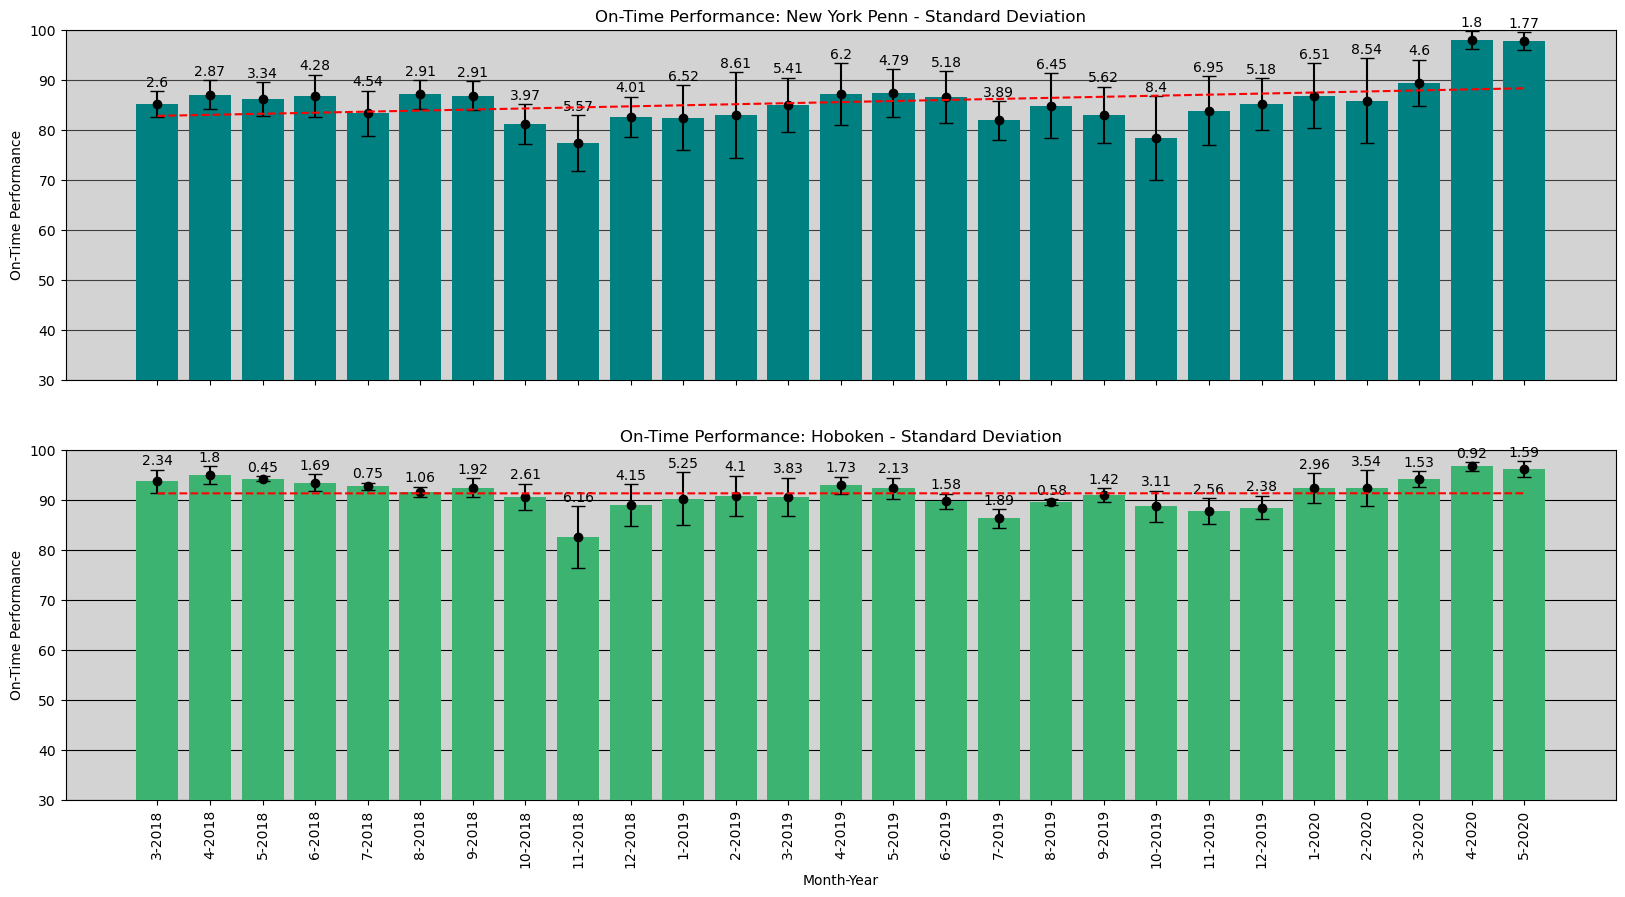

In [12]:

all_services['date'] = pd.to_datetime(all_services['date'])
all_services['year'] = all_services['date'].dt.year
all_services['month'] = all_services['date'].dt.month

otps_by_month_year_ny = all_services.groupby(['year', 'month']).apply(lambda x: np.mean(helper.otp_for_destination(x, 'New York Penn Station')))
std_devs_by_month_year_ny = all_services.groupby(['year', 'month']).apply(lambda x: helper.calculate_std_dev(helper.otp_for_destination(x, 'New York Penn Station')))
otps_by_month_year_hoboken = all_services.groupby(['year', 'month']).apply(lambda x: np.mean(helper.otp_for_destination(x, 'Hoboken')))
std_devs_by_month_year_hoboken = all_services.groupby(['year', 'month']).apply(lambda x: helper.calculate_std_dev(helper.otp_for_destination(x, 'Hoboken')))

x_labels = [f"{month}-{year}" for year, month in otps_by_month_year_ny.index]
xpos = np.arange(len(otps_by_month_year_ny))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Plot New York Penn data
ax1.bar(xpos, otps_by_month_year_ny, color='teal', zorder=3)
ax1.errorbar(xpos, otps_by_month_year_ny, yerr=std_devs_by_month_year_ny, fmt='o', color='black', zorder=3, capsize=5)
for i, (mean, std_dev) in enumerate(zip(otps_by_month_year_ny, std_devs_by_month_year_ny)):
    ax1.text(i, mean + std_dev + 1, round(std_dev, 2), horizontalalignment='center')
slope, intercept = np.polyfit(xpos, otps_by_month_year_ny, 1)
ax1.plot(xpos, slope*xpos + intercept, color='red', linestyle='--',zorder=6)
ax1.set_facecolor('lightgray')
ax1.set_ylabel('On-Time Performance')
ax1.set_ylim([30, 100])
ax1.set_title('On-Time Performance: New York Penn - Standard Deviation')

# Plot Hoboken data
ax2.bar(xpos, otps_by_month_year_hoboken, color='mediumseagreen', zorder=3)
ax2.errorbar(xpos, otps_by_month_year_hoboken, yerr=std_devs_by_month_year_hoboken, fmt='o', color='black', zorder=3,capsize=5)
for i, (mean, std_dev) in enumerate(zip(otps_by_month_year_hoboken, std_devs_by_month_year_hoboken)):
    ax2.text(i, mean + std_dev + 1, round(std_dev, 2), horizontalalignment='center')
slope, intercept = np.polyfit(xpos, otps_by_month_year_hoboken, 1)
ax2.plot(xpos, slope*xpos + intercept, color='red', linestyle='--',zorder=6)
ax2.set_xlabel('Month-Year')
ax2.set_ylabel('On-Time Performance')
ax2.set_ylim([30, 100])
ax2.set_title('On-Time Performance: Hoboken - Standard Deviation')
ax1.grid(axis='y', linestyle='-', alpha=0.7,color='black',zorder=0)
ax2.grid(axis='y', linestyle='-', color='black', zorder = 0)
ax2.set_facecolor('lightgray')
plt.xticks(xpos, x_labels, rotation=90)
plt.show()


## Use With Weather Data 

Probability of Being Late During Inclement Weather

In [7]:
rainy_days = weather[(weather['PRCP'] > 0.0)]
## Merge CSVs
merged_data = pd.merge(all_services[(all_services['to'] == 'New York Penn Station') ^ (all_services['to'] == 'Hoboken')],weather, on=['date'])
merged_data['rain/snow'] = (merged_data['PRCP'] > 0) # create boolean value 

total_srvcs = len(merged_data)
prcp_srvcs = len(merged_data[merged_data['rain/snow']])
late_srvcs = len(merged_data[merged_data['delay_minutes'] >= 6.0])
probability_of_late = len(merged_data[(merged_data['delay_minutes'] >= 6) & (merged_data['rain/snow'])]) / prcp_srvcs

print('Total number of trains:', total_srvcs)
print('Total number of trains running on rainy days:', prcp_srvcs)
print('Total number of late trains:', late_srvcs)
print('Probability of late trains given rain:', probability_of_late)

: 

: 

In [ ]:
services2018 = all_services[(all_services['date'].dt.year == 2018)]
merged_data_18 = pd.merge(services2018,weather, on=['date'])

x = merged_data_18['delay_minutes'].to_list()
y = merged_data_18['PRCP'].to_list()

x = random.sample(x, 1000)
y = random.sample(y, 1000)

plt.scatter(x,y)
plt.xlabel('Minutes Delayed')
plt.ylabel('Precipitation')
plt.show()

#### Density Functions<br>
Delay minutes are measured in seconds and stored as float64 values so we'll be using continuous distribution functions.<br>

Probability Density Function can be used to calculate the likelihood of an observed value in a distribution.<br>

Cumulative Density Funtion calculates the cumulative liklihood of an observed value 

In [ ]:
# NEW YORK PENN
helper.print_prob_cdf(all_services, 'New York Penn Station')
trains_to_nyp = all_services[(all_services['to'] == 'New York Penn Station')]
delay_minutes = trains_to_nyp['delay_minutes']

### Draw random sample
mu = np.mean(delay_minutes)
sigma = statistics.stdev(delay_minutes)
data = np.random.normal(loc=mu, scale=sigma, size=1000)
data.sort()
delay_minutes = np.array(delay_minutes)
min_val = floor(min(delay_minutes))
max_val = ceil(max(delay_minutes))
### Plot
fig = plt.gcf()

plt.subplot(1,1,1)
x = np.arange(min_val, max_val)

pdf = stats.norm.pdf(x, loc=mu, scale=sigma)
plt.plot(x, pdf, label='$\mu = {mu}, $\sigma={sigma}')
plt.title('PDF of Normal Distributions')
plt.legend(loc='upper left')
plt.xlabel('X-value')
plt.ylabel('Probability Density')
plt.xlim([min_val, max_val])
plt.grid()
plt.show()

plt.plot()
print(x)
# HOBOKEN TERMINAL
helper.print_prob_cdf(all_services, 'Hoboken')
